In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [2]:
from math import ceil
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
from jax import random

from tqdm import tqdm


from functools import partial
from jax import jit

In [3]:
from bpd.pipelines import pipeline_toy_ellips, pipeline_shear_inference_simple


# Shape noise = 0.01

## Standard approach n_gals = 10**4

In [5]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-2
sigma_e_int = 5e-2
sigma_m = 1e-5
n_gals = 10000
n_samples_per_gal = 300

In [6]:
k1, k2 = random.split(key)

In [7]:
# positive shear
e1e2p, e_obs, _ = pipeline_toy_ellips(k1, g1=g1, g2=g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [8]:
# negative shear (same key!)
e1e2m, _, _ = pipeline_toy_ellips(k1, g1=-g1, g2=-g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [9]:
e1e2p.shape, e1e2m.shape, e_obs.shape

((10000, 300, 2), (10000, 300, 2), (10000, 2))

(array([  2.,   4.,   4.,   5.,   3.,   5.,  17.,  18.,  34.,  45.,  42.,
         77., 107., 129., 168., 213., 265., 293., 396., 413., 480., 519.,
        484., 605., 608., 575., 519., 561., 516., 495., 434., 375., 333.,
        279., 221., 196., 147., 111.,  88.,  68.,  54.,  35.,  20.,  15.,
          9.,   7.,   3.,   0.,   1.,   1.,   1.]),
 array([-0.0175776 , -0.01609285, -0.0146081 , -0.01312335, -0.0116386 ,
        -0.01015385, -0.0086691 , -0.00718436, -0.00569961, -0.00421486,
        -0.00273011, -0.00124536,  0.00023939,  0.00172414,  0.00320889,
         0.00469364,  0.00617839,  0.00766314,  0.00914789,  0.01063263,
         0.01211738,  0.01360213,  0.01508688,  0.01657163,  0.01805638,
         0.01954113,  0.02102588,  0.02251063,  0.02399538,  0.02548013,
         0.02696487,  0.02844962,  0.02993437,  0.03141912,  0.03290387,
         0.03438862,  0.03587337,  0.03735812,  0.03884287,  0.04032762,
         0.04181237,  0.04329712,  0.04478186,  0.04626661,  0.04775

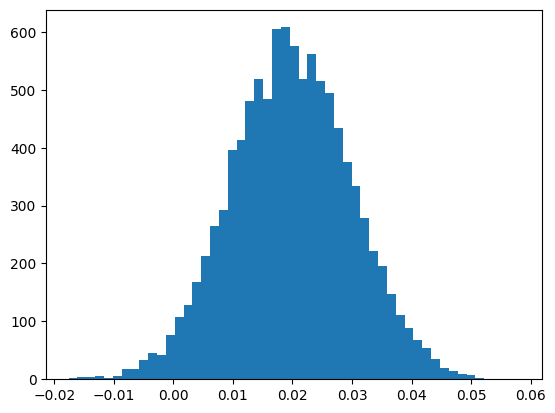

In [10]:
plt.hist(e_obs[:, 0], bins=51)

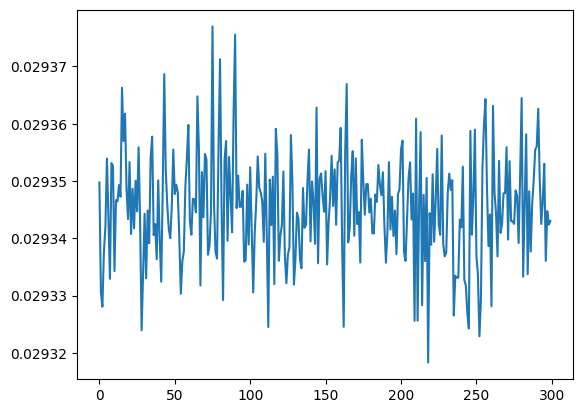

In [11]:
plt.plot(e1e2p[3, :, 0])

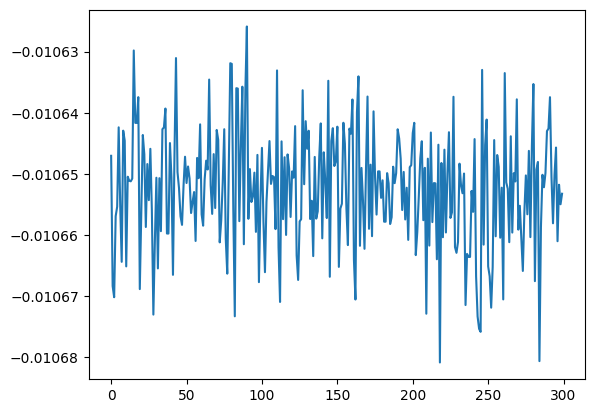

In [12]:
plt.plot(e1e2m[3, :, 0])

In [13]:
_pipe = partial(pipeline_shear_inference_simple,
                init_g=jnp.array([0.0,0.0]),
                sigma_e=sigma_e, 
                sigma_e_int=sigma_e_int,
                n_samples=3000,
                initial_step_size=0.01
               )
pipe = jit(_pipe)

In [14]:
e1e2p.shape

(10000, 300, 2)

In [36]:
gp_full = pipe(k2, e1e2p)

In [37]:
gm_full = pipe(k2, e1e2m)

In [38]:
gp_full.shape, gm_full.shape

((3000, 2), (3000, 2))

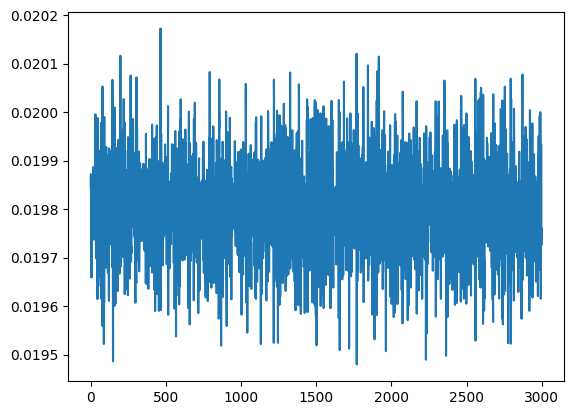

In [39]:
plt.plot(gp_full[:, 0])

In [40]:
(gp_full[:, 0].mean() - gm_full[:, 0].mean()) / 0.02 / 2 - 1

Array(-9.99296589e-05, dtype=float64)

In [41]:
gp_full[:, 0].std() / np.sqrt(len(gp_full[:, 0])), gm_full[:, 0].std() / np.sqrt(len(gm_full[:, 0]))

(Array(1.82786157e-06, dtype=float64), Array(1.82783566e-06, dtype=float64))

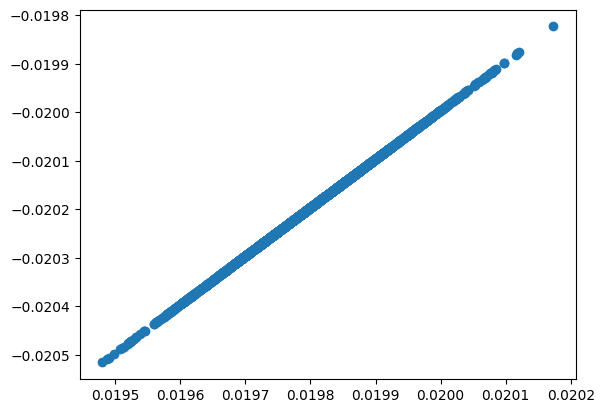

In [42]:
plt.scatter(gp_full[:, 0], gm_full[:, 0])

In [43]:
x = (gp_full[:, 0] - gm_full[:, 0]) / 2 / 0.02 - 1
x.mean(), x.std(), x.var()

(Array(-9.99296589e-05, dtype=float64),
 Array(1.8360536e-07, dtype=float64),
 Array(3.37109284e-14, dtype=float64))

In [44]:
_cov = np.cov(gp_full[:, 0], gm_full[:, 0])
var_m = (1 / (4 * 0.02**2)) * ( _cov[0,0] + _cov[1,1] - 2 * _cov[0, 1])
np.sqrt(var_m)

np.float64(1.8363596690277428e-07)

## What if we do a bootstrap? 

In [22]:
from jax import vmap

In [23]:
# shear with bootstrap 
n_boots = 100

gps = [] 
gms = [] 

k2s = random.split(k2, n_boots) 

for ii in tqdm(range(n_boots)):

    k_ii = k2s[ii]
    _k1, _k2 = random.split(k_ii)
    
    indices = random.randint(_k1, minval=0, maxval=n_gals, shape=(n_gals,))

    _e1e2p = e1e2p[indices]
    _e1e2m = e1e2m[indices]
    assert _e1e2p.shape[0] == n_gals
    
    _gp = pipe(_k2, _e1e2p)
    _gm = pipe(_k2, _e1e2m)

    gps.append(_gp)
    gms.append(_gm)
    
    

100%|██████████| 100/100 [45:16<00:00, 27.16s/it]


In [25]:
gps = jnp.stack(gps, axis=0)
gps.shape

(100, 3000, 2)

In [26]:
gms = jnp.stack(gms, axis=0)
gms.shape

(100, 3000, 2)

In [27]:
jnp.save("gp_boot2.npy", gps)
jnp.save("gm_boot2.npy", gms)

In [28]:
mboot = (gps[:, :, 0].mean(axis=1) - gms[:, :, 0].mean(axis=1)) / 2 / 0.02 - 1

In [29]:
mboot.shape

(100,)

(array([ 3.,  2.,  7.,  9., 57., 13.,  5.,  2.,  0.,  2.]),
 array([-1.80466859e-04, -1.63683047e-04, -1.46899236e-04, -1.30115424e-04,
        -1.13331613e-04, -9.65478015e-05, -7.97639900e-05, -6.29801786e-05,
        -4.61963671e-05, -2.94125556e-05, -1.26287442e-05]),
 <BarContainer object of 10 artists>)

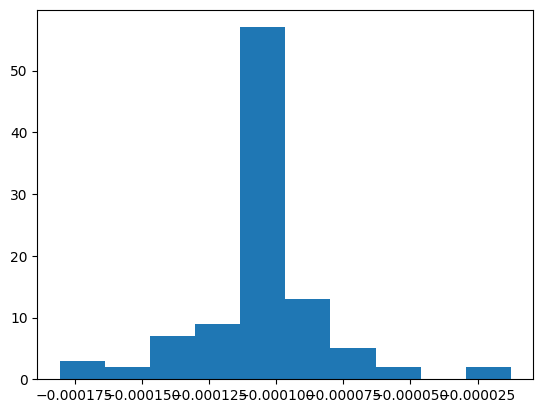

In [30]:
plt.hist(mboot)

In [31]:
mboot.mean(), mboot.std() 

(Array(-0.00010405, dtype=float64), Array(2.38141753e-05, dtype=float64))

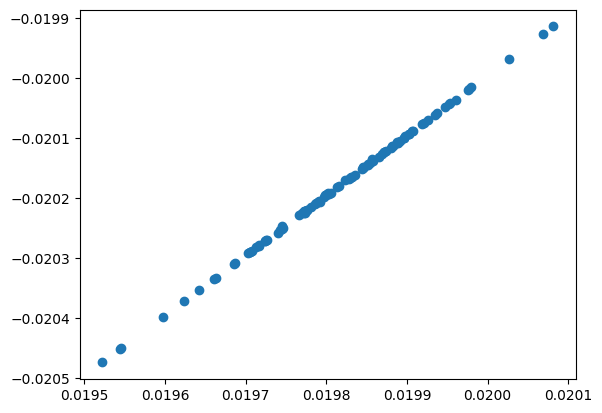

In [32]:
plt.scatter(gps[:, :, 0].mean(axis=1), gms[:, :, 0].mean(axis=1))

In [33]:
g1p = gps[:, :, 0].mean(axis=1)
g1m = gms[:, :, 0].mean(axis=1)

In [34]:
np.cov(g1p, g1m)

array([[1.11086591e-08, 1.11066980e-08],
       [1.11066980e-08, 1.11056535e-08]])

In [35]:
_cov = np.cov(g1p, g1m)
var_m = (1 / (4 * 0.02**2)) * ( _cov[0,0] + _cov[1,1] - 2 * _cov[0, 1])
np.sqrt(var_m)

np.float64(2.393414669770512e-05)

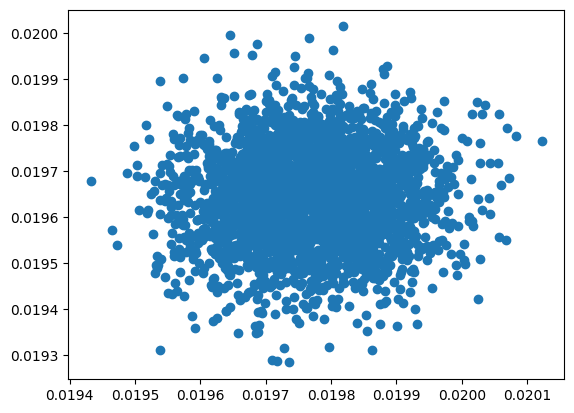

In [41]:
plt.scatter(gps[0, :, 0], gps[2, :, 0])

In [39]:
np.cov(gps[0, :, 0], gps[1, :, 0])

array([[9.70543999e-09, 3.80214435e-11],
       [3.80214435e-11, 1.02220125e-08]])

In [38]:
np.cov(gps[0, :, 0], gms[1, :, 0])

array([[9.70543999e-09, 4.92383560e-11],
       [4.92383560e-11, 1.02256890e-08]])

## What if we process galaxies in chunks? 

In [45]:
n_blocks = 100
size = int(n_gals / n_blocks)
k2s = random.split(k2, n_blocks)

In [46]:
size, n_gals, n_blocks

(100, 10000, 100)

In [48]:
gps = [] 
gms = []

for ii in tqdm(range(n_blocks)):
    start, end = ii * size, (ii+1) * size
    _e1e2p = e1e2p[start:end]
    _e1e2m = e1e2m[start:end]

    gps.append(pipe(k2s[ii], _e1e2p)) 
    gms.append(pipe(k2s[ii], _e1e2m))

    
    

100%|██████████| 100/100 [09:17<00:00,  5.57s/it]


In [50]:
gps1 = jnp.stack(gps, axis=0)
gms1 = jnp.stack(gms, axis=0)
gps1.shape

(100, 3000, 2)

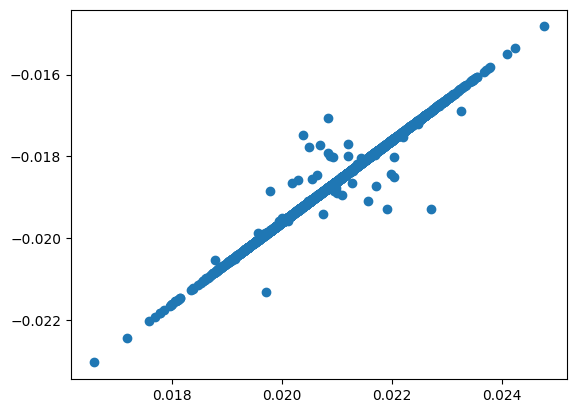

In [51]:
plt.scatter(gps1[0, :, 0], gms1[0, :, 0])

In [52]:
m1 = (gps1[...,0].mean(axis=1) - gms1[...,0].mean(axis=1)) / 2 / 0.02 - 1

In [53]:
m1.shape

(100,)

(array([ 2.,  0.,  3.,  6., 13., 44., 20.,  8.,  1.,  3.]),
 array([-0.01085019, -0.01068112, -0.01051205, -0.01034298, -0.01017391,
        -0.01000484, -0.00983577, -0.00966669, -0.00949762, -0.00932855,
        -0.00915948]),
 <BarContainer object of 10 artists>)

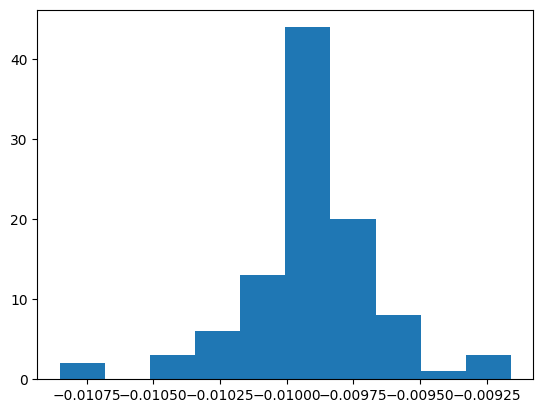

In [54]:
plt.hist(m1)

In [56]:
m1.mean(), m1.std()

(Array(-0.00990047, dtype=float64), Array(0.00024726, dtype=float64))

## what about different seeds for + and - ? 

In [7]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-2
sigma_e_int = 5e-2
sigma_m = 1e-5
n_gals = 10000
n_samples_per_gal = 300

In [47]:
k1, k2 = random.split(key)

In [48]:
# positive shear

# in this case we want same galaxies so same key, later we might split up galaxies from chains ellipticities but lets' see for now
e1e2p, e_obs, _ = pipeline_toy_ellips(k1, g1=g1, g2=g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [49]:
# negative shear 
e1e2m, _, _ = pipeline_toy_ellips(k1, g1=-g1, g2=-g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [50]:
e1e2p.shape, e1e2m.shape, e_obs.shape

((10000, 300, 2), (10000, 300, 2), (10000, 2))

In [51]:
_pipe = partial(pipeline_shear_inference_simple,
                init_g=jnp.array([0.0,0.0]),
                sigma_e=sigma_e, 
                sigma_e_int=sigma_e_int,
                n_samples=3000,
                initial_step_size=0.01
               )
pipe = jit(_pipe)

In [52]:
e1e2p.shape

(10000, 300, 2)

In [53]:
k12, k22 = random.split(k2)

In [54]:
gp_full = pipe(k12, e1e2p)

In [55]:
gm_full = pipe(k22, e1e2m)

In [56]:
gp_full.shape, gm_full.shape

((3000, 2), (3000, 2))

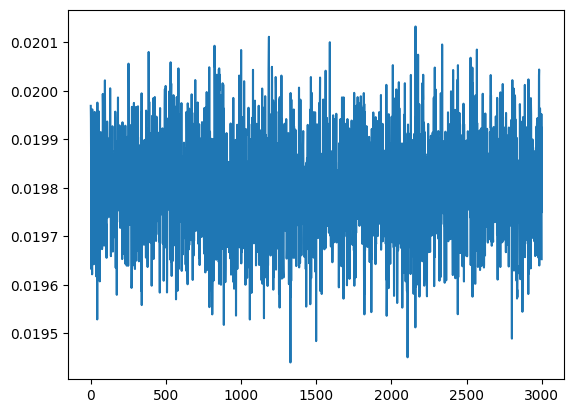

In [57]:
plt.plot(gp_full[:, 0])

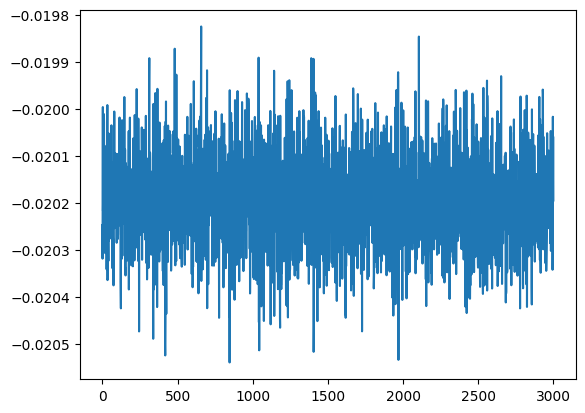

In [58]:
plt.plot(gm_full[:, 0])

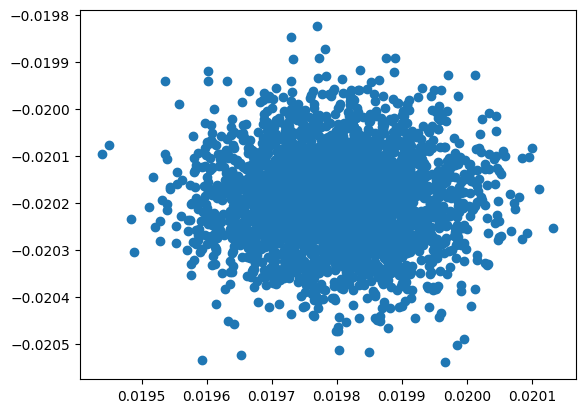

In [59]:
plt.scatter(gp_full[:, 0], gm_full[:, 0])
# samples are not correlated one to one

In [60]:
m_full = (gp_full[:, 0].mean() - gm_full[:, 0].mean()) / 2 / 0.02 - 1
m_full

Array(-0.00010856, dtype=float64)

In [61]:
gp_full[:, 0].std(), gm_full[:,0].std()

(Array(0.00010078, dtype=float64), Array(9.75426072e-05, dtype=float64))

In [62]:
## bootstrap
# shear with bootstrap 
n_boots = 10

gps = [] 
gms = [] 

k2s = random.split(k2, (n_boots,))

for ii in tqdm(range(n_boots)):

    k_ii = k2s[ii]
    _k1, _k2, _k3 = random.split(k_ii, 3)
    
    indices = random.randint(_k1, minval=0, maxval=n_gals, shape=(n_gals,))

    _e1e2p = e1e2p[indices]
    _e1e2m = e1e2m[indices]
    assert _e1e2p.shape[0] == n_gals
    
    _gp = pipe(_k2, _e1e2p)
    _gm = pipe(_k3, _e1e2m)

    gps.append(_gp)
    gms.append(_gm)
    
    


100%|██████████| 10/10 [04:31<00:00, 27.13s/it]


In [63]:
gps1 = jnp.stack(gps, axis=0)
gms1 = jnp.stack(gms, axis=0)
gps1.shape

(10, 3000, 2)

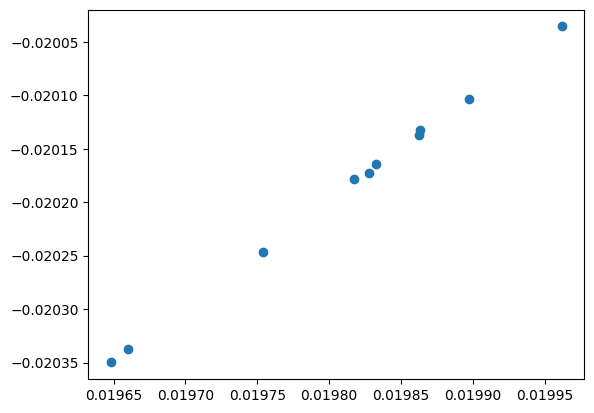

In [64]:
plt.scatter(gps1[...,0].mean(axis=1), gms1[...,0].mean(axis=1))

In [65]:
m1s = (gps1[...,0].mean(axis=1) -  gms1[...,0].mean(axis=1)) / 2 / 0.02 - 1 

In [69]:
m_full, m1s.mean(), m1s.std()

(Array(-0.00010856, dtype=float64),
 Array(-4.01258345e-05, dtype=float64),
 Array(4.71979964e-05, dtype=float64),
 Array(0.00010147, dtype=float64))

## Standard approach n_gals = 10**3

What happens with less galaxies? 

In [7]:
seed = 42
key = random.key(seed)

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])

sigma_e = 1e-2
sigma_e_int = 5e-2
sigma_m = 1e-5
n_gals = 1000
n_samples_per_gal = 300

In [8]:
k1, k2 = random.split(key)

In [9]:
# positive shear
e1e2p, _, _ = pipeline_toy_ellips(k1, g1=g1, g2=g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [10]:
# negative shear (same key!)
e1e2m, _, _ = pipeline_toy_ellips(k1, g1=-g1, g2=-g2, 
                                  sigma_e=sigma_e, sigma_e_int=sigma_e_int, 
                                  sigma_m=sigma_m, n_gals=n_gals, n_samples_per_gal=n_samples_per_gal)

In [11]:
e1e2p.shape, e1e2m.shape

((1000, 300, 2), (1000, 300, 2))

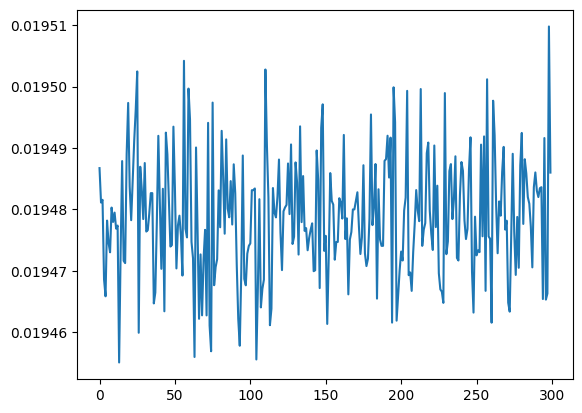

In [12]:
plt.plot(e1e2p[3, :, 0])

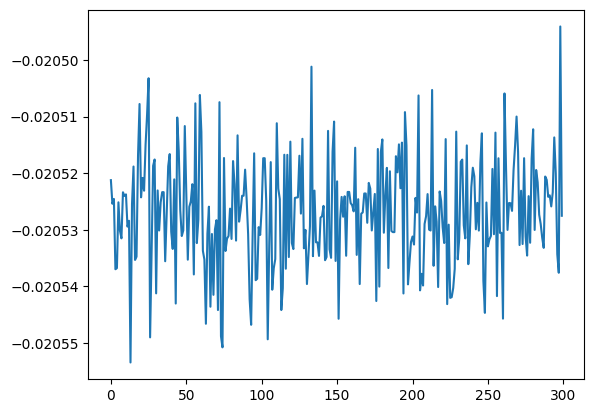

In [13]:
plt.plot(e1e2m[3, :, 0])

In [14]:
_pipe = partial(pipeline_shear_inference_simple,
                init_g=jnp.array([0.0,0.0]),
                sigma_e=sigma_e, 
                sigma_e_int=sigma_e_int,
                n_samples=3000,
                initial_step_size=0.01
               )
pipe = jit(_pipe)

In [15]:
e1e2p.shape

(1000, 300, 2)

In [16]:
gp_full = pipe(k2, e1e2p)

In [17]:
gm_full = pipe(k2, e1e2m)

In [18]:
gp_full.shape, gm_full.shape

((3000, 2), (3000, 2))

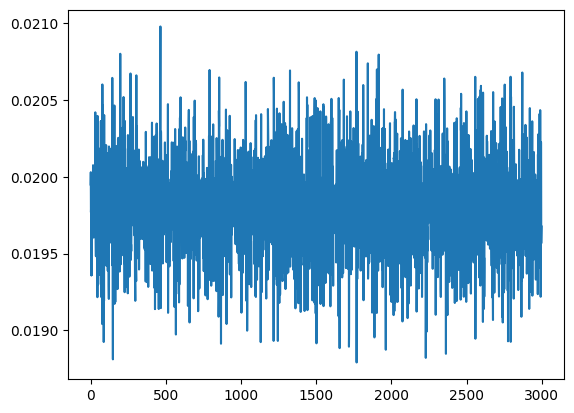

In [19]:
plt.plot(gp_full[:, 0])

In [20]:
(gp_full[:, 0].mean() - gm_full[:, 0].mean()) / 0.02 / 2 - 1

Array(-0.00099629, dtype=float64)

In [21]:
gp_full[:, 0].std() / np.sqrt(len(gp_full[:, 0])), gm_full[:, 0].std() / np.sqrt(len(gm_full[:, 0]))

(Array(5.77773114e-06, dtype=float64), Array(5.77766109e-06, dtype=float64))

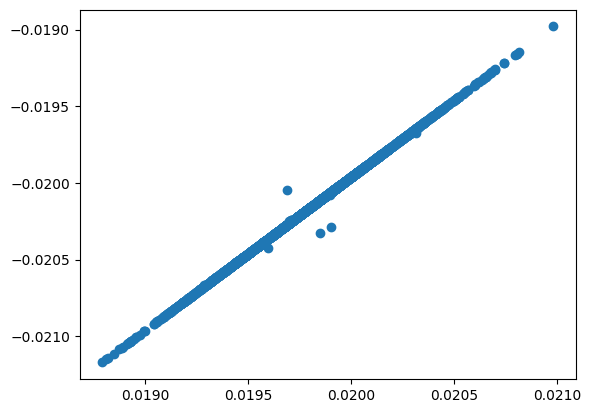

In [22]:
plt.scatter(gp_full[:, 0], gm_full[:, 0])

In [23]:
x = (gp_full[:, 0] - gm_full[:, 0]) / 2 / 0.02 - 1
x.mean(), x.std(), x.var()

(Array(-0.00099629, dtype=float64),
 Array(0.00017715, dtype=float64),
 Array(3.1383771e-08, dtype=float64))

In [24]:
_cov = np.cov(gp_full[:, 0], gm_full[:, 0])
var_m = (1 / (4 * 0.02**2)) * ( _cov[0,0] + _cov[1,1] - 2 * _cov[0, 1])
np.sqrt(var_m)

np.float64(0.00017718418593345612)